In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import defaultdict
from urllib import request
import os
import pandas as pd
import numpy as np
from urllib import request
import cv2
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import os
from tensorflow.keras.applications import VGG16
import json
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import tensorflow
import tensorflow as tf
from collections import deque

In [3]:
file_path='data'

In [6]:
import splitfolders
splitted_folder='./splitted_folder'
def train_test_valid(train_size=0.6,test_size=0.2,val_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  val_size = val_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size,val_size), group_prefix = None)
train_test_valid()

Copying files: 4188 files [00:02, 2030.32 files/s]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_file_path = './splitted_folder/train'
test_file_path =  './splitted_folder/test'
val_file_path =  './splitted_folder/val'

def data_pre_processing(valid_split = 0,input_size = (260, 260),image_color = 'rgb',batch_size = 32,
                        shuffle=True):


    train_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split,fill_mode='nearest',rotation_range=40,horizontal_flip=True)

    validation_gen=ImageDataGenerator(rescale=1/255.0,validation_split=valid_split)

    test_gen=ImageDataGenerator(rescale=1/255.0)

    train_data=train_gen.flow_from_directory(directory=train_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    test_data=test_gen.flow_from_directory(directory=test_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')
    valid_data=validation_gen.flow_from_directory(directory=val_file_path,target_size=input_size,color_mode=image_color,
                                             batch_size=batch_size,shuffle=shuffle,class_mode='categorical')

    return train_data,test_data,valid_data

train,test,validation=data_pre_processing()

Found 2511 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


# EXPLORATION

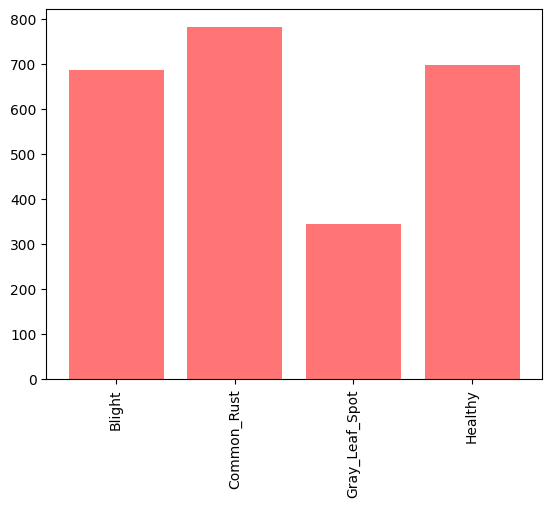

In [8]:
values_counter=Counter(train.classes)
sorted(values_counter.items())
plt.bar(train.class_indices.keys(), values_counter.values(), color=(1, 0.1, 0.1, 0.6))
plt.xticks(rotation=90)
plt.show()

In [9]:
labels=dict()
for label_name,label_num in train.class_indices.items():
        labels[label_num]=label_name

100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


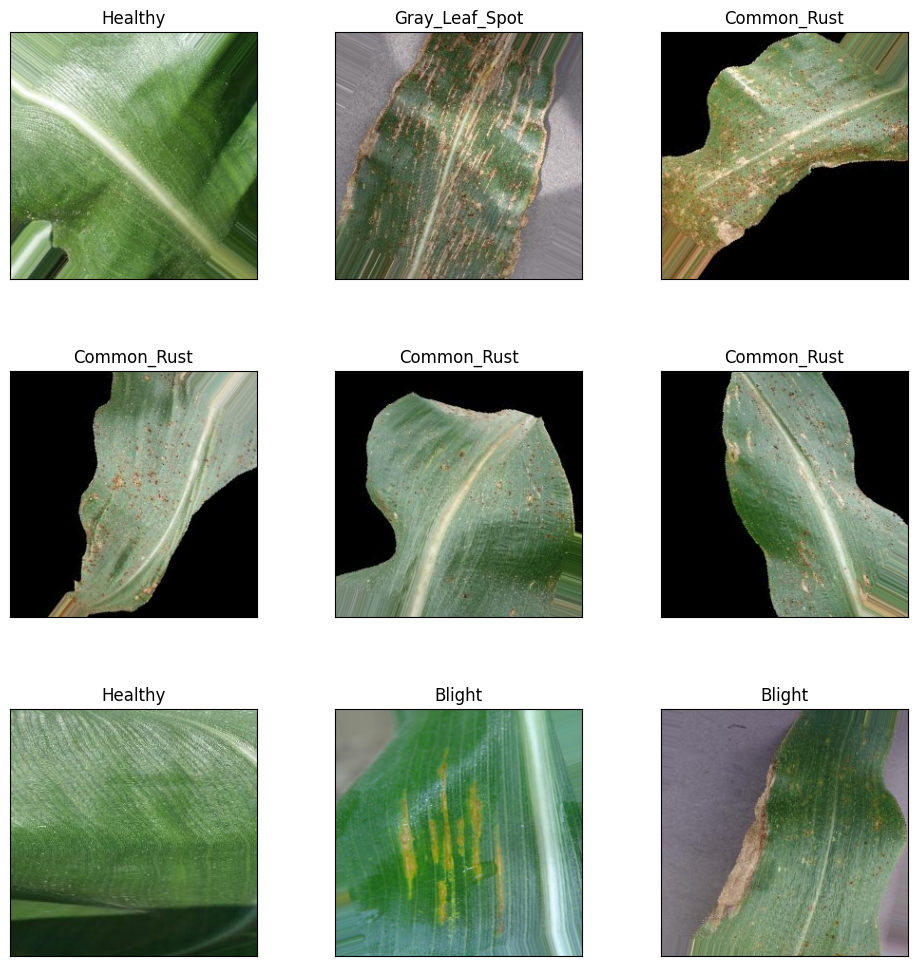

In [10]:
plt.figure(figsize=(10,10))
for i in tqdm(range(9)):
    plt.subplot(3,3,i+1)
    for x_batch,y_batch in train:
        image=x_batch[0]
        argmax=np.argmax(y_batch)
        plt.tight_layout(h_pad=5)
        plt.title(labels[argmax])
        plt.xticks(())
        plt.yticks(())
        plt.imshow(image)
        break

In [11]:
import efficientnet.tfkeras as enet

In [12]:
def configure_model():
  inputs_1 = tf.keras.Input(shape=(260, 260, 3))
  mymodel=enet.EfficientNetB2(input_shape = (260, 260, 3), include_top = False, weights = 'imagenet')
  x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(mymodel.output)
  x = tf.keras.layers.Flatten()(x)
  predictors = tf.keras.layers.Dense(4,activation='softmax',name='Predictions')(x)
  final_model = Model(mymodel.input, outputs=predictors)
  return final_model
final_model=configure_model()

31936256/31936256 ━━━━━━━━━━━━━━━━━━━━ 52s 2us/step


In [13]:
def model(new_model=final_model,layers_num=1,trainable=False):
    for layer in new_model.layers[:layers_num]:
        layer.trainable=trainable
    return new_model
final_model=model(final_model)

In [14]:
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [15]:
opt=tf.keras.optimizers.Adam(0.0001)
final_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
def callbacks(patience=2):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('my_model.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,min_delta=0.001)
    lr=tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks_list=[checkpoint, early,lr]
    return callbacks_list

In [19]:
callbacks=callbacks()

In [20]:
counter = Counter(train.classes)                          
max_val = float(max(counter.values()))       
class_weights1 = {class_id : max_val/num_images for class_id, num_images in counter.items()}   

In [24]:
hist=final_model.fit(train,
                     epochs=3,
                     validation_data=(validation),
                     callbacks=callbacks,
                     class_weight=class_weights1)

Epoch 1/3


2024-10-09 15:32:17.149795: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.59607846, 0.66925377, 0.5914896 ],
         [0.5859992 , 0.65091294, 0.57684135],
         [0.5037903 , 0.5551891 , 0.48439166],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5921588 , 0.6679751 , 0.5901971 ],
         [0.59607846, 0.6645098 , 0.58911765],
         [0.5314428 , 0.5868686 , 0.515169  ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5842356 , 0.662693  , 0.58623546],
         [0.59607846, 0.6671508 , 0.5904382 ],
         [0.5618151 , 0.6225229 , 0.54

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.59607846, 0.66925377, 0.5914896 ],
         [0.5859992 , 0.65091294, 0.57684135],
         [0.5037903 , 0.5551891 , 0.48439166],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5921588 , 0.6679751 , 0.5901971 ],
         [0.59607846, 0.6645098 , 0.58911765],
         [0.5314428 , 0.5868686 , 0.515169  ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5842356 , 0.662693  , 0.58623546],
         [0.59607846, 0.6671508 , 0.5904382 ],
         [0.5618151 , 0.6225229 , 0.5495028 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.4406974 , 0.42108956, 0.44461897],
         [0.4420723 , 0.42246446, 0.44599387],
         [0.44282737, 0.42321953, 0.44674894],
         ...,
         [0.47249284, 0.46857125, 0.53131634],
         [0.4632055 , 0.45928392, 0.522029  ],
         [0.46030524, 0.45638368, 0.5191288 ]],

        [[0.43483377, 0.41522592, 0.43875533],
         [0.43758357, 0.41797572, 0.44150513],
         [0.43977454, 0.4201667 , 0.4436961 ],
         ...,
         [0.46836817, 0.4644466 , 0.5271917 ],
         [0.46045572, 0.45653415, 0.51927924],
         [0.46168014, 0.45775858, 0.52050364]],

        [[0.4274885 , 0.40788066, 0.43141007],
         [0.43023828, 0.41063043, 0.43415985],
         [0.43298805, 0.4133802 , 0.43690962],
         ...,
         [0.4650512 , 0.46112964, 0.52387476],
         [0.45938239, 0.45546082, 0.51820594],
         [0.46367484, 0.45975327, 0.52249837]],

        ...,

        [[0.4286906 , 0.42383933, 0.44220757],
         [0.4341765 , 0.42352945, 0.44986278],
         [0.44463563, 0.42664328, 0.44475278],
         ...,
         [0.53333336, 0.52156866, 0.54901963],
         [0.53333336, 0.52156866, 0.54901963],
         [0.53333336, 0.52156866, 0.54901963]],

        [[0.429581  , 0.42352945, 0.44526726],
         [0.43774235, 0.42434552, 0.44934827],
         [0.4498946 , 0.427451  , 0.4414358 ],
         ...,
         [0.5327745 , 0.5210098 , 0.5484608 ],
         [0.53333336, 0.52156866, 0.54901963],
         [0.53333336, 0.52156866, 0.54901963]],

        [[0.43233076, 0.42352945, 0.44801703],
         [0.44186702, 0.4257204 , 0.44659847],
         [0.45676908, 0.427451  , 0.43731114],
         ...,
         [0.5291019 , 0.5173372 , 0.5447882 ],
         [0.5304768 , 0.5187121 , 0.5461631 ],
         [0.53185165, 0.52008694, 0.5475379 ]]],


       [[[0.27027997, 0.242829  , 0.27027997],
         [0.2887367 , 0.26128572, 0.2887367 ],
         [0.30588236, 0.2784314 , 0.30588236],
         ...,
         [0.60784316, 0.5882353 , 0.6039216 ],
         [0.60784316, 0.5882353 , 0.6039216 ],
         [0.60784316, 0.5882353 , 0.6039216 ]],

        [[0.2693396 , 0.24188864, 0.2693396 ],
         [0.28497526, 0.25752428, 0.28497526],
         [0.30588236, 0.2784314 , 0.30588236],
         ...,
         [0.61035717, 0.5907493 , 0.6064356 ],
         [0.6117677 , 0.59215987, 0.60784614],
         [0.61317825, 0.5935704 , 0.6092567 ]],

        [[0.26839924, 0.24094827, 0.26839924],
         [0.28121382, 0.25376284, 0.28121382],
         [0.30588236, 0.2784314 , 0.30588236],
         ...,
         [0.6244662 , 0.60485834, 0.6205446 ],
         [0.62728727, 0.60767937, 0.6233657 ],
         [0.6301083 , 0.61050045, 0.6261867 ]],

        ...,

        [[0.5046181 , 0.57520634, 0.33991224],
         [0.501797  , 0.57238525, 0.33709112],
         [0.49897593, 0.5695642 , 0.33427003],
         ...,
         [0.6258316 , 0.60622376, 0.6297532 ],
         [0.6336181 , 0.6140103 , 0.6375397 ],
         [0.66279167, 0.6431838 , 0.66671324]],

        [[0.5091201 , 0.57970834, 0.34012783],
         [0.5124114 , 0.58299965, 0.34247872],
         [0.51570266, 0.5862909 , 0.34482962],
         ...,
         [0.6248912 , 0.6052834 , 0.6288128 ],
         [0.6326778 , 0.61306995, 0.63659936],
         [0.65856004, 0.6389522 , 0.6624816 ]],

        [[0.5046493 , 0.5752375 , 0.33210027],
         [0.5008879 , 0.5714761 , 0.32833883],
         [0.4971264 , 0.56771463, 0.3245774 ],
         ...,
         [0.6239509 , 0.60434306, 0.62787247],
         [0.6317374 , 0.61212957, 0.635659  ],
         [0.65432847, 0.6347206 , 0.65825003]]],


       ...,


       [[[0.44151473, 0.400074  , 0.2230379 ],
         [0.43768823, 0.39418265, 0.21789621],
         [0.44743392, 0.402429  , 0.22689223],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.48730874, 0.45790896, 0.2770236 ],
         [0.47561008, 0.4434681 , 0.2633324 ],
         [0.46736372, 0.43297273, 0.25358674],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5498614 , 0.5350168 , 0.35028222],
         [0.54310113, 0.5260997 , 0.34211472],
         [0.5296071 , 0.50960696, 0.3263717 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.37908328, 0.46815926, 0.31428427],
         [0.32510227, 0.4084614 , 0.2555202 ],
         [0.37588128, 0.45823425, 0.30529305],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.38957867, 0.47640562, 0.3232803 ],
         [0.3078599 , 0.3904693 , 0.23752815],
         [0.39537266, 0.4777256 , 0.32478443],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.37915018, 0.4648592 , 0.311918  ],
         [0.31478366, 0.3971366 , 0.2441954 ],
         [0.4035007 , 0.48459107, 0.33207077],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.33932653, 0.54448146, 0.45759022],
         [0.33986983, 0.54379135, 0.4575169 ],
         [0.3379465 , 0.5418681 , 0.45559356],
         ...,
         [0.39176548, 0.5917655 , 0.51725566],
         [0.38834792, 0.588348  , 0.5138381 ],
         [0.39815006, 0.6047599 , 0.5269451 ]],

        [[0.32974967, 0.54151434, 0.4513183 ],
         [0.33484387, 0.5429872 , 0.4546018 ],
         [0.34061384, 0.54491055, 0.45844847],
         ...,
         [0.38984215, 0.58984214, 0.51533234],
         [0.39366743, 0.59728885, 0.5209683 ],
         [0.39608005, 0.60392314, 0.5254918 ]],

        [[0.34000224, 0.551767  , 0.4615709 ],
         [0.3342323 , 0.545997  , 0.45580095],
         [0.33036122, 0.541493  , 0.4516134 ],
         ...,
         [0.38918474, 0.5898177 , 0.51499146],
         [0.39943737, 0.6069054 , 0.5286616 ],
         [0.39031008, 0.59815323, 0.51972187]],

        ...,

        [[0.35247758, 0.56032073, 0.44267365],
         [0.36900258, 0.57684577, 0.45919865],
         [0.37583765, 0.5836808 , 0.46603373],
         ...,
         [0.38665292, 0.60170627, 0.52687997],
         [0.38502163, 0.60070795, 0.5261981 ],
         [0.38117498, 0.59686124, 0.52235144]],

        [[0.36209416, 0.5699373 , 0.45229024],
         [0.37284923, 0.58069235, 0.4630453 ],
         [0.37647063, 0.58431375, 0.4666667 ],
         ...,
         [0.36956525, 0.57778347, 0.4995397 ],
         [0.37918183, 0.5912468 , 0.51492625],
         [0.38801005, 0.60369635, 0.52918655]],

        [[0.3698608 , 0.57770395, 0.46005687],
         [0.37647063, 0.58431375, 0.4666667 ],
         [0.37647063, 0.58431375, 0.4666667 ],
         ...,
         [0.37508744, 0.5829306 , 0.5044992 ],
         [0.3712408 , 0.5790839 , 0.50065255],
         [0.37171078, 0.58078724, 0.5029725 ]]],


       [[[0.5241077 , 0.49273515, 0.54371554],
         [0.5158613 , 0.4844887 , 0.5354691 ],
         [0.49597394, 0.4646014 , 0.51558185],
         ...,
         [0.3736727 , 0.36975113, 0.35406485],
         [0.3681502 , 0.36422864, 0.34854236],
         [0.36262769, 0.35870612, 0.34301984]],

        [[0.5199658 , 0.48859328, 0.53957367],
         [0.5200031 , 0.48863056, 0.5396109 ],
         [0.50425774, 0.47288516, 0.5238656 ],
         ...,
         [0.35764542, 0.35237864, 0.33803758],
         [0.34798107, 0.33857238, 0.32837322],
         [0.3383167 , 0.32476616, 0.31870884]],

        [[0.515824  , 0.4844514 , 0.53543186],
         [0.524145  , 0.49277243, 0.54375285],
         [0.5125414 , 0.4811689 , 0.53214926],
         ...,
         [0.33293867, 0.3172524 , 0.31333083],
         [0.33017743, 0.31449115, 0.31056958],
         [0.32741618, 0.3117299 , 0.30780834]],

        ...,

        [[0.561817  , 0.534366  , 0.56573856],
         [0.5576751 , 0.53022414, 0.5615967 ],
         [0.55353326, 0.5260823 , 0.5574548 ],
         ...,
         [0.43038583, 0.47823405, 0.3221607 ],
         [0.50083566, 0.5444213 , 0.37713912],
         [0.50980395, 0.55616325, 0.37786958]],

        [[0.554365  , 0.526914  , 0.55828655],
         [0.5571262 , 0.52967525, 0.5610478 ],
         [0.55988747, 0.5324365 , 0.56380904],
         ...,
         [0.42348275, 0.47685343, 0.32630256],
         [0.47322318, 0.5181895 , 0.35504916],
         [0.50980395, 0.5547827 , 0.38063082]],

        [[0.5635494 , 0.5360984 , 0.56747097],
         [0.57183313, 0.54438215, 0.5757547 ],
         [0.58011687, 0.5526659 , 0.58403844],
         ...,
         [0.4165796 , 0.4754728 , 0.33044443],
         [0.44561073, 0.49195766, 0.33295918],
         [0.50980395, 0.553402  , 0.38339207]]]], dtype=float32), array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)).
Traceback (most recent call last):

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/data/util/nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/util/nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/envs/cv/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.59607846, 0.66925377, 0.5914896 ],
         [0.5859992 , 0.65091294, 0.57684135],
         [0.5037903 , 0.5551891 , 0.48439166],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5921588 , 0.6679751 , 0.5901971 ],
         [0.59607846, 0.6645098 , 0.58911765],
         [0.5314428 , 0.5868686 , 0.515169  ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5842356 , 0.662693  , 0.58623546],
         [0.59607846, 0.6671508 , 0.5904382 ],
         [0.5618151 , 0.6225229 , 0.5495028 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.4406974 , 0.42108956, 0.44461897],
         [0.4420723 , 0.42246446, 0.44599387],
         [0.44282737, 0.42321953, 0.44674894],
         ...,
         [0.47249284, 0.46857125, 0.53131634],
         [0.4632055 , 0.45928392, 0.522029  ],
         [0.46030524, 0.45638368, 0.5191288 ]],

        [[0.43483377, 0.41522592, 0.43875533],
         [0.43758357, 0.41797572, 0.44150513],
         [0.43977454, 0.4201667 , 0.4436961 ],
         ...,
         [0.46836817, 0.4644466 , 0.5271917 ],
         [0.46045572, 0.45653415, 0.51927924],
         [0.46168014, 0.45775858, 0.52050364]],

        [[0.4274885 , 0.40788066, 0.43141007],
         [0.43023828, 0.41063043, 0.43415985],
         [0.43298805, 0.4133802 , 0.43690962],
         ...,
         [0.4650512 , 0.46112964, 0.52387476],
         [0.45938239, 0.45546082, 0.51820594],
         [0.46367484, 0.45975327, 0.52249837]],

        ...,

        [[0.4286906 , 0.42383933, 0.44220757],
         [0.4341765 , 0.42352945, 0.44986278],
         [0.44463563, 0.42664328, 0.44475278],
         ...,
         [0.53333336, 0.52156866, 0.54901963],
         [0.53333336, 0.52156866, 0.54901963],
         [0.53333336, 0.52156866, 0.54901963]],

        [[0.429581  , 0.42352945, 0.44526726],
         [0.43774235, 0.42434552, 0.44934827],
         [0.4498946 , 0.427451  , 0.4414358 ],
         ...,
         [0.5327745 , 0.5210098 , 0.5484608 ],
         [0.53333336, 0.52156866, 0.54901963],
         [0.53333336, 0.52156866, 0.54901963]],

        [[0.43233076, 0.42352945, 0.44801703],
         [0.44186702, 0.4257204 , 0.44659847],
         [0.45676908, 0.427451  , 0.43731114],
         ...,
         [0.5291019 , 0.5173372 , 0.5447882 ],
         [0.5304768 , 0.5187121 , 0.5461631 ],
         [0.53185165, 0.52008694, 0.5475379 ]]],


       [[[0.27027997, 0.242829  , 0.27027997],
         [0.2887367 , 0.26128572, 0.2887367 ],
         [0.30588236, 0.2784314 , 0.30588236],
         ...,
         [0.60784316, 0.5882353 , 0.6039216 ],
         [0.60784316, 0.5882353 , 0.6039216 ],
         [0.60784316, 0.5882353 , 0.6039216 ]],

        [[0.2693396 , 0.24188864, 0.2693396 ],
         [0.28497526, 0.25752428, 0.28497526],
         [0.30588236, 0.2784314 , 0.30588236],
         ...,
         [0.61035717, 0.5907493 , 0.6064356 ],
         [0.6117677 , 0.59215987, 0.60784614],
         [0.61317825, 0.5935704 , 0.6092567 ]],

        [[0.26839924, 0.24094827, 0.26839924],
         [0.28121382, 0.25376284, 0.28121382],
         [0.30588236, 0.2784314 , 0.30588236],
         ...,
         [0.6244662 , 0.60485834, 0.6205446 ],
         [0.62728727, 0.60767937, 0.6233657 ],
         [0.6301083 , 0.61050045, 0.6261867 ]],

        ...,

        [[0.5046181 , 0.57520634, 0.33991224],
         [0.501797  , 0.57238525, 0.33709112],
         [0.49897593, 0.5695642 , 0.33427003],
         ...,
         [0.6258316 , 0.60622376, 0.6297532 ],
         [0.6336181 , 0.6140103 , 0.6375397 ],
         [0.66279167, 0.6431838 , 0.66671324]],

        [[0.5091201 , 0.57970834, 0.34012783],
         [0.5124114 , 0.58299965, 0.34247872],
         [0.51570266, 0.5862909 , 0.34482962],
         ...,
         [0.6248912 , 0.6052834 , 0.6288128 ],
         [0.6326778 , 0.61306995, 0.63659936],
         [0.65856004, 0.6389522 , 0.6624816 ]],

        [[0.5046493 , 0.5752375 , 0.33210027],
         [0.5008879 , 0.5714761 , 0.32833883],
         [0.4971264 , 0.56771463, 0.3245774 ],
         ...,
         [0.6239509 , 0.60434306, 0.62787247],
         [0.6317374 , 0.61212957, 0.635659  ],
         [0.65432847, 0.6347206 , 0.65825003]]],


       ...,


       [[[0.44151473, 0.400074  , 0.2230379 ],
         [0.43768823, 0.39418265, 0.21789621],
         [0.44743392, 0.402429  , 0.22689223],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.48730874, 0.45790896, 0.2770236 ],
         [0.47561008, 0.4434681 , 0.2633324 ],
         [0.46736372, 0.43297273, 0.25358674],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5498614 , 0.5350168 , 0.35028222],
         [0.54310113, 0.5260997 , 0.34211472],
         [0.5296071 , 0.50960696, 0.3263717 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.37908328, 0.46815926, 0.31428427],
         [0.32510227, 0.4084614 , 0.2555202 ],
         [0.37588128, 0.45823425, 0.30529305],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.38957867, 0.47640562, 0.3232803 ],
         [0.3078599 , 0.3904693 , 0.23752815],
         [0.39537266, 0.4777256 , 0.32478443],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.37915018, 0.4648592 , 0.311918  ],
         [0.31478366, 0.3971366 , 0.2441954 ],
         [0.4035007 , 0.48459107, 0.33207077],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.33932653, 0.54448146, 0.45759022],
         [0.33986983, 0.54379135, 0.4575169 ],
         [0.3379465 , 0.5418681 , 0.45559356],
         ...,
         [0.39176548, 0.5917655 , 0.51725566],
         [0.38834792, 0.588348  , 0.5138381 ],
         [0.39815006, 0.6047599 , 0.5269451 ]],

        [[0.32974967, 0.54151434, 0.4513183 ],
         [0.33484387, 0.5429872 , 0.4546018 ],
         [0.34061384, 0.54491055, 0.45844847],
         ...,
         [0.38984215, 0.58984214, 0.51533234],
         [0.39366743, 0.59728885, 0.5209683 ],
         [0.39608005, 0.60392314, 0.5254918 ]],

        [[0.34000224, 0.551767  , 0.4615709 ],
         [0.3342323 , 0.545997  , 0.45580095],
         [0.33036122, 0.541493  , 0.4516134 ],
         ...,
         [0.38918474, 0.5898177 , 0.51499146],
         [0.39943737, 0.6069054 , 0.5286616 ],
         [0.39031008, 0.59815323, 0.51972187]],

        ...,

        [[0.35247758, 0.56032073, 0.44267365],
         [0.36900258, 0.57684577, 0.45919865],
         [0.37583765, 0.5836808 , 0.46603373],
         ...,
         [0.38665292, 0.60170627, 0.52687997],
         [0.38502163, 0.60070795, 0.5261981 ],
         [0.38117498, 0.59686124, 0.52235144]],

        [[0.36209416, 0.5699373 , 0.45229024],
         [0.37284923, 0.58069235, 0.4630453 ],
         [0.37647063, 0.58431375, 0.4666667 ],
         ...,
         [0.36956525, 0.57778347, 0.4995397 ],
         [0.37918183, 0.5912468 , 0.51492625],
         [0.38801005, 0.60369635, 0.52918655]],

        [[0.3698608 , 0.57770395, 0.46005687],
         [0.37647063, 0.58431375, 0.4666667 ],
         [0.37647063, 0.58431375, 0.4666667 ],
         ...,
         [0.37508744, 0.5829306 , 0.5044992 ],
         [0.3712408 , 0.5790839 , 0.50065255],
         [0.37171078, 0.58078724, 0.5029725 ]]],


       [[[0.5241077 , 0.49273515, 0.54371554],
         [0.5158613 , 0.4844887 , 0.5354691 ],
         [0.49597394, 0.4646014 , 0.51558185],
         ...,
         [0.3736727 , 0.36975113, 0.35406485],
         [0.3681502 , 0.36422864, 0.34854236],
         [0.36262769, 0.35870612, 0.34301984]],

        [[0.5199658 , 0.48859328, 0.53957367],
         [0.5200031 , 0.48863056, 0.5396109 ],
         [0.50425774, 0.47288516, 0.5238656 ],
         ...,
         [0.35764542, 0.35237864, 0.33803758],
         [0.34798107, 0.33857238, 0.32837322],
         [0.3383167 , 0.32476616, 0.31870884]],

        [[0.515824  , 0.4844514 , 0.53543186],
         [0.524145  , 0.49277243, 0.54375285],
         [0.5125414 , 0.4811689 , 0.53214926],
         ...,
         [0.33293867, 0.3172524 , 0.31333083],
         [0.33017743, 0.31449115, 0.31056958],
         [0.32741618, 0.3117299 , 0.30780834]],

        ...,

        [[0.561817  , 0.534366  , 0.56573856],
         [0.5576751 , 0.53022414, 0.5615967 ],
         [0.55353326, 0.5260823 , 0.5574548 ],
         ...,
         [0.43038583, 0.47823405, 0.3221607 ],
         [0.50083566, 0.5444213 , 0.37713912],
         [0.50980395, 0.55616325, 0.37786958]],

        [[0.554365  , 0.526914  , 0.55828655],
         [0.5571262 , 0.52967525, 0.5610478 ],
         [0.55988747, 0.5324365 , 0.56380904],
         ...,
         [0.42348275, 0.47685343, 0.32630256],
         [0.47322318, 0.5181895 , 0.35504916],
         [0.50980395, 0.5547827 , 0.38063082]],

        [[0.5635494 , 0.5360984 , 0.56747097],
         [0.57183313, 0.54438215, 0.5757547 ],
         [0.58011687, 0.5526659 , 0.58403844],
         ...,
         [0.4165796 , 0.4754728 , 0.33044443],
         [0.44561073, 0.49195766, 0.33295918],
         [0.50980395, 0.553402  , 0.38339207]]]], dtype=float32), array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_66903]

2024-10-09 15:32:17.544957: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.58187926, 0.6658813 , 0.60623324],
         [0.46911222, 0.5593083 , 0.49656323],
         [0.57861197, 0.6688717 , 0.6061266 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.596755  , 0.67910796, 0.62028444],
         [0.50578326, 0.59349734, 0.5319932 ],
         [0.52850425, 0.6187003 , 0.55595523],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.5596833 , 0.64203626, 0.58321273],
         [0.57487136, 0.6592153 , 0.5993963 ],
         [0.47458175, 0.56477785, 0.50

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["accuracy","Validation Loss"])
plt.show()

NameError: name 'hist' is not defined

<Figure size 1000x1000 with 0 Axes>

In [26]:
plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["loss","Validation Loss"])
plt.show()

NameError: name 'hist' is not defined

<Figure size 1000x1000 with 0 Axes>

In [22]:
y_real=[]
all_pred=[]
count=0
for x,y in test:
  predict=final_model.predict(x)
  
  for i in predict:
    all_pred.append(np.argmax(i)+1)
  for i in y:
    i=np.argmax(i)+1
    y_real.append(i)

  if len(y_real)==len(test.filepaths):
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━

In [23]:
target_names =[]
for key,value in test.class_indices.items():
  target_names.append(f'condition: {key}')


In [27]:
from sklearn import metrics
report=metrics.classification_report(y_real,all_pred,target_names=target_names)
conf_efficnet2=metrics.confusion_matrix(y_real,all_pred)

In [28]:
import itertools
def plot_confusion_matrix(cnf_matrix, numbers_type='numbers_and_percentage', class_names=target_names, title='Confusion matrix', cmap=plt.cm.Blues, file_name='confusionmatrix.png'):
    combined = True
    cnf_matrix_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = 0.8*cnf_matrix.max() / 1.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if numbers_type == 'numbers_and_percentage':
            st1 = '{:.2f}%'.format(100 * cnf_matrix_normalized[i, j])
            st2 = '({:2d})'.format(cnf_matrix[i, j])
            plt.text(j, i, st1+st2,
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

        elif numbers_type == 'percentage':
            fmt = '.2f'
            plt.text(j, i, format(cnf_matrix_normalized[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        else:
            fmt = 'd'
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center", verticalalignment='bottom',
                     color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(file_name)

    return


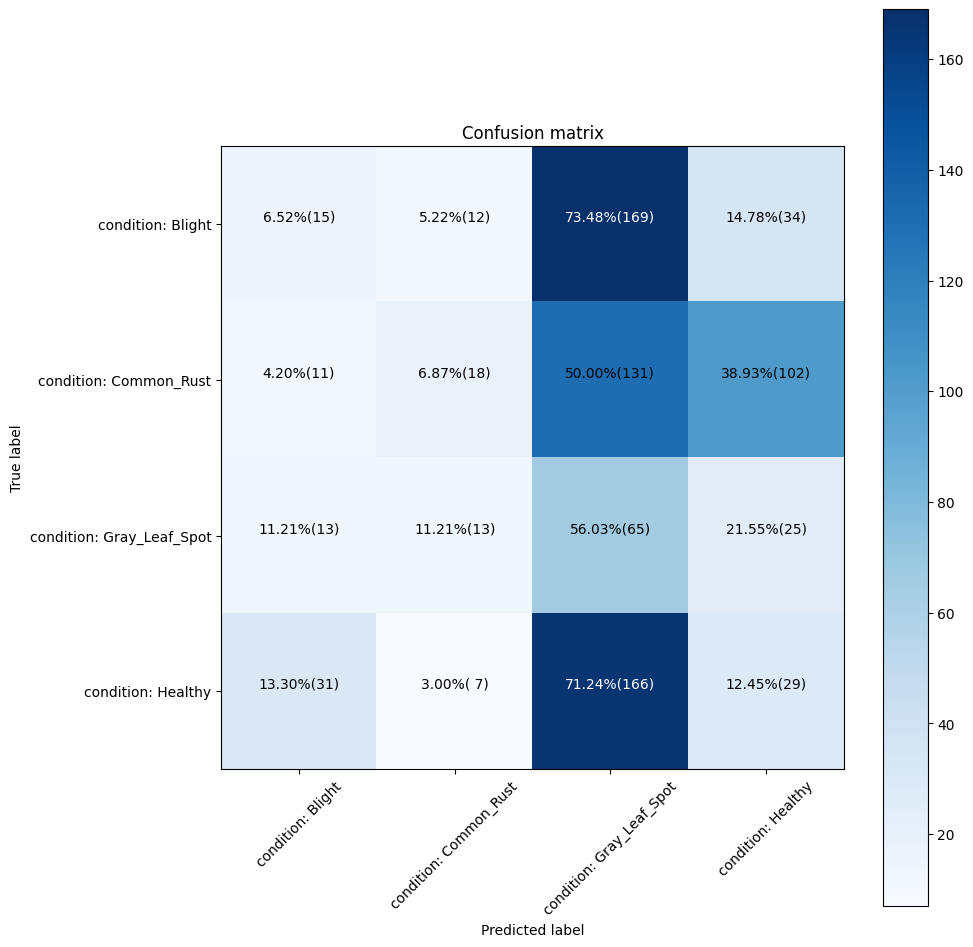

In [29]:
plot_confusion_matrix(conf_efficnet2)